In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from utils import plot_confusion_matrix, plot_confusion_matrix, get_gzipped_model_size
from data_organizer_Kfall import DataOrganizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
from keras import models, optimizers, callbacks
from keras.utils import to_categorical
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from models.ConvLSTM import ConvLSTM
from models.ConvLSTM_VGG import ConvLSTM_VGG
from models.TinyFallNet import TinyFallNet
from models.ResNet24 import ResNet24
from models.TinyFallNet_6axis import TinyFallNet_6axis



# Model Config

In [3]:
model_name = "TinyFallNet_6axis" # "ConvLSTM" or "ConvLSTM_VGG" or "TinyFallNet" or "ResNet24" or "TinyFallNet_6axis"
load_from_checkpoint = False

if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

if load_from_checkpoint:
    model = models.load_model('./saved_models/'+model_name+'.keras')
else:
    if model_name == "ConvLSTM":
        model = ConvLSTM()
    elif model_name == "ConvLSTM_VGG":
        model = ConvLSTM_VGG()
    elif model_name == "TinyFallNet":
        model = TinyFallNet()
    elif model_name == "ResNet24":
        model = ResNet24()
    elif model_name == "TinyFallNet_6axis":
        model = TinyFallNet_6axis()
    else:
        print("Please select a valid model name")
    

# Data Loader

In [5]:
# mac
sensor_data_folder = '/Users/liuxinqing/Documents/Kfall/sensor_data'  # Update with the path to sensor data
label_data_folder = '/Users/liuxinqing/Documents/Kfall/label_data'  
# windows 
#sensor_data_folder = 'G:\MLonMCU\Kfall_dataset\sensor_data'  # Update with the path to sensor data
#label_data_folder = 'G:\MLonMCU\Kfall_dataset\label_data' 
# linux
# sensor_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/sensor_data'  # Update with the path to sensor data
# label_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/label_data'  

#window_size = 256
# Kfall: window_size = 50
window_size = 50
threshold = 0.4
num_window_fall_data = 50
num_window_not_fall_data = 5
mode = 'ACC+GYRO' # 'ACC' or 'ACC+GYRO' or 'ACC+GYRO+MAG'

data, label = DataOrganizer(sensor_data_folder, 
                            label_data_folder, 
                            window_size, 
                            threshold, 
                            num_window_fall_data, 
                            num_window_not_fall_data,
                            mode)

in_channels = data.shape[2]

print('in_channels: ', in_channels)
# the input data should have the shape (batch_size, in_channels, sequence_length)
#data = data.reshape(data.shape[0], in_channels, -1)
print('data.shape: ', data.shape)

label = label.astype(np.int64)
# one-hot encoding
#label = to_categorical(label, num_classes=2)
# transpose the data to (batch_size, sequence_length, in_channels)
#data = np.transpose(data, (0, 2, 1))
data = data.reshape(data.shape[0], 50, in_channels)
# normalize the data
# Initialize a new scaling object for normalizing input data
# Z-score normalization

# (y == 0).sum()
B_size = (label == 0).sum()
A_size = (label == 1).sum()
print('B_size: ', B_size)	
print('A_size: ', A_size)
# transpose the data to (batch_size, in_channels, sequence_length)
#data = np.transpose(data, (0, 2, 1))
print('data: ', data[0][0])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(np.unique(y_train)) # [0 1]
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

# select the test data that is not zero
X_test_true = X_test[y_test != 0]
y_test_true = y_test[y_test != 0]
# length of the test data
test_len = X_test_true.shape[0]
X_test_false = X_test[y_test == 0]
y_test_false = y_test[y_test == 0]
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
index = np.random.choice(X_test_false.shape[0], test_len, replace=False)
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
#index = np.random.choice(X_test_false.shape[0], len, replace=False)

X_test_false = X_test[index]
y_test_false = y_test[index]

# concatenate the true and false test data
X_test = np.concatenate((X_test_true, X_test_false), axis=0)
y_test = np.concatenate((y_test_true, y_test_false), axis=0)
#X_test = X_test[y_test != 0]
#y_test = y_test[y_test != 0]
print(X_test.shape)

Processing 1/32 folder...
Processing 2/32 folder...
Processing 3/32 folder...
Processing 4/32 folder...
Processing 5/32 folder...
Processing 6/32 folder...
Processing 7/32 folder...
Processing 8/32 folder...
Processing 9/32 folder...
Processing 10/32 folder...
Processing 11/32 folder...
Processing 12/32 folder...
Processing 13/32 folder...
Processing 14/32 folder...
Processing 15/32 folder...
Processing 16/32 folder...
Processing 17/32 folder...
Processing 18/32 folder...
Processing 19/32 folder...
Processing 20/32 folder...
Processing 21/32 folder...
Processing 22/32 folder...
Processing 23/32 folder...
Processing 24/32 folder...
Processing 25/32 folder...
Processing 26/32 folder...
Processing 27/32 folder...
Processing 28/32 folder...
Processing 29/32 folder...
Processing 30/32 folder...
Processing 31/32 folder...
Processing 32/32 folder...
in_channels:  6
data.shape:  (25576, 50, 6)
B_size:  25020
A_size:  556
data:  [ 0.02      -0.996      0.16      -1.9480572 -1.2032118  0.5156622

# Hyperparameters

In [6]:
# Hyperparameters
learning_rate = 5e-4
batch_size = 64
epochs = 50
factor = 0.5
patience = 5

# Model Training

In [7]:
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), 
            loss='categorical_crossentropy',
            #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
model.build(input_shape=(None, 50, 9))
model.summary()


Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 6)]              0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 50, 6)             0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 1, 48, 64)            1216      ['reshape[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 1, 24, 64)            0         ['conv2d[0][0]']              
 D)                                                                                     

In [8]:
""" train(train_dataloader, model_ConvLSTM, loss_fn, optimizer,val_dataloader, 
           patience=patience, scheduler=scheduler, epochs=epochs, device=device, B_size=B_size, A_size=A_size) """
# Train the model
# Train the model without using batches
# Compile the model
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

# Calculate class weights
B_multiplier = 1
A_multiplier = B_size / A_size
class_weight = {0: B_multiplier, 1: A_multiplier}

# Ensure y_train and y_val are one-hot encoded only once
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
lrs = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
print('y_train.shape: ', y_train.shape) # (23291,)

history = model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[es, lrs],
          class_weight=class_weight) 

y_train.shape:  (16368, 2)
y_val.shape:  (4092, 2)
X_train.shape:  (16368, 50, 6)
y_train.shape:  (16368, 2)
Epoch 1/50
256/256 [==============================] - 5s 14ms/step - loss: 1.6908 - accuracy: 0.7769 - val_loss: 0.6435 - val_accuracy: 0.8174 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 4s 14ms/step - loss: 0.7314 - accuracy: 0.8744 - val_loss: 0.3822 - val_accuracy: 0.8942 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 4s 14ms/step - loss: 0.6046 - accuracy: 0.8906 - val_loss: 0.2549 - val_accuracy: 0.9338 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 4s 14ms/step - loss: 0.6364 - accuracy: 0.8860 - val_loss: 0.3913 - val_accuracy: 0.8675 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 4s 14ms/step - loss: 0.5619 - accuracy: 0.8924 - val_loss: 0.3148 - val_accuracy: 0.9052 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 4s 14ms/step - loss: 0.4604 - accurac

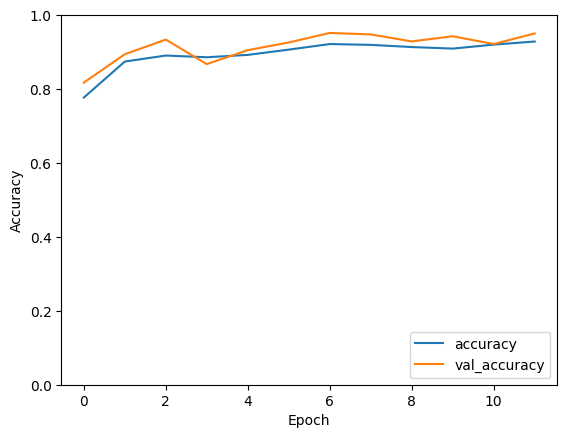

In [9]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Model Evaluation

In [10]:
# Evaluate the model
print('X_test.shape: ', X_test.shape)
if y_test.ndim == 1:
    y_test = to_categorical(y_test)
test_loss = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)

X_test.shape:  (250, 50, 6)
8/8 - 0s - loss: 0.5075 - accuracy: 0.8480 - 47ms/epoch - 6ms/step
Test loss: [0.5075323581695557, 0.8479999899864197]


8/8 [==============================] - 0s 2ms/step
[[114   4]
 [ 34  98]]
Confusion matrix, without normalization
[[114   4]
 [ 34  98]]
accuracy:  0.848
f1_score:  0.8376068376068376


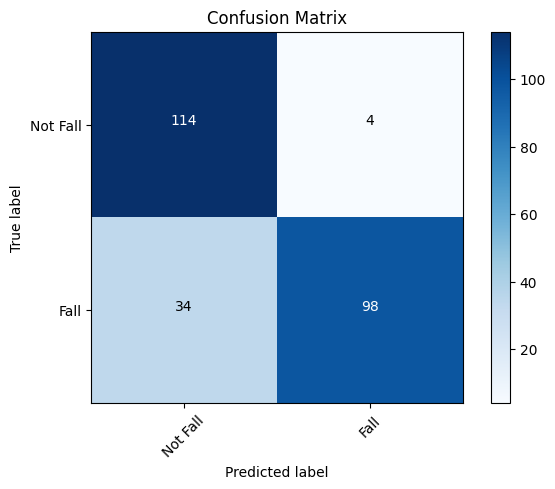

In [11]:
# Convert y_test back to its original form
y_test_original = np.argmax(y_test, axis=-1)

# Get the model's predictions
predictions = np.argmax(model.predict(X_test), axis=-1)


# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
print('accuracy: ', accuracy_fp)
# f1 score
precision_fp = cm[1][1] / (cm[1][1] + cm[0][1])
recall_fp = cm[1][1] / (cm[1][1] + cm[1][0])
f1_score_fp = 2 * precision_fp * recall_fp / (precision_fp + recall_fp)
print('f1_score: ', f1_score_fp)


# Save Model

In [12]:
model.save('./saved_models/'+model_name+'.keras')
# convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
if model_name=="ConvLSTM" or model_name=="ConvLSTM_VGG":
    converter._experimental_lower_tensor_list_ops = False
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
model_tflite = converter.convert()
# save the model
open('./saved_models/'+model_name+'.tflite', "wb").write(model_tflite)


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpdsxr0trs/assets


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpdsxr0trs/assets
2023-12-14 10:28:52.617859: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-14 10:28:52.617877: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-14 10:28:52.618482: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpdsxr0trs
2023-12-14 10:28:52.624089: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-14 10:28:52.624102: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpdsxr0trs
2023-12-14 10:28:52.634415: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-14 10:28:52.639917: I tensorflow/cc/saved_model/load

139040

# Quantization

In [13]:
# only for ConvLSTM model
if model_name=="ConvLSTM" or model_name=="ConvLSTM_VGG":
    def representative_data_gen():
        for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
            yield [input_value]

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
    converter._experimental_lower_tensor_list_ops = False
    converter.inference_input_type = tf.float32
    converter.inference_output_type = tf.int8

    tflite_q_model = converter.convert()
    interpreter = tf.lite.Interpreter(model_content=tflite_q_model)
    input_type = interpreter.get_input_details()[0]['dtype']
    print('input: ', input_type)
    output_type = interpreter.get_output_details()[0]['dtype']
    print('output: ', output_type)
    # Save the quantized model to disk
    open('./saved_models/'+model_name+'_q.tflite', "wb").write(tflite_q_model)
    

In [14]:
q_model = tfmot.quantization.keras.quantize_model(model)
q_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

q_model.summary()


Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 6)]              0         []                            
                                                                                                  
 quantize_layer (QuantizeLa  (None, 50, 6)                3         ['input_1[0][0]']             
 yer)                                                                                             
                                                                                                  
 quant_reshape (QuantizeWra  (None, 1, 50, 6)             1         ['quantize_layer[0][0]']      
 pperV2)                                                                                          
                                                                                        

In [15]:
q_model.save('./saved_models/'+model_name+'_q.keras')
# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(q_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# This is required for full integer quantization (including input and output)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32  # Keep input as float32
converter.inference_output_type = tf.int8  # Keep output as float32

# Convert the model
tflite_q_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_q_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open('./saved_models/'+model_name+'_q.tflite', "wb").write(tflite_q_model)


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp_ttt0cor/assets


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp_ttt0cor/assets
/Users/liuxinqing/opt/anaconda3/envs/fall_detection/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-12-14 10:29:00.220262: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-14 10:29:00.220277: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-14 10:29:00.220464: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp_ttt0cor
2023-12-14 10:29:00.231921: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-14 10:29:00.231940: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/6j/7v41

input:  <class 'numpy.float32'>
output:  <class 'numpy.int8'>


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: INT8


69080

# QAT

In [16]:
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

q_history = q_model.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs],
            class_weight=class_weight) 

y_train.shape:  (16368, 2)
y_val.shape:  (4092, 2)
Epoch 1/50
256/256 [==============================] - 7s 19ms/step - loss: 0.6160 - accuracy: 0.8427 - val_loss: 0.1017 - val_accuracy: 0.9673 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 5s 20ms/step - loss: 0.4432 - accuracy: 0.8972 - val_loss: 0.2280 - val_accuracy: 0.9157 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 5s 20ms/step - loss: 0.3770 - accuracy: 0.9209 - val_loss: 0.3353 - val_accuracy: 0.8952 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 5s 20ms/step - loss: 0.3939 - accuracy: 0.9169 - val_loss: 0.2487 - val_accuracy: 0.9311 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 5s 21ms/step - loss: 0.3859 - accuracy: 0.9227 - val_loss: 0.2295 - val_accuracy: 0.9260 - lr: 5.0000e-04
Epoch 6/50
255/256 [============================>.] - ETA: 0s - loss: 0.3192 - accuracy: 0.9365
Epoch 6: ReduceLROnPlateau reducing learning rate to 

In [17]:
q_model.save('./saved_models/'+model_name+'_qat.keras')  # The file needs to end with the .keras extension
# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(q_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# This is required for full integer quantization (including input and output)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32  # Keep input as float32
converter.inference_output_type = tf.int8  # Keep output as float32

# Convert the model
tflite_q_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_q_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open('./saved_models/'+model_name+'_qat.tflite', "wb").write(tflite_q_model)


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp_a7_4jyl/assets


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp_a7_4jyl/assets
/Users/liuxinqing/opt/anaconda3/envs/fall_detection/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-12-14 10:29:40.679652: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-14 10:29:40.679666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-14 10:29:40.679840: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmp_a7_4jyl
2023-12-14 10:29:40.693855: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-14 10:29:40.693873: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/6j/7v41

input:  <class 'numpy.float32'>
output:  <class 'numpy.int8'>


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: INT8


69312

# Prune

In [18]:
# Unstrucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
}

ups = pruning_callbacks.UpdatePruningStep()
# Create a pruning model
pruned_model_unstructured = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured.summary()


Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 6)]              0         []                            
                                                                                                  
 prune_low_magnitude_reshap  (None, 1, 50, 6)             1         ['input_1[0][0]']             
 e (PruneLowMagnitude)                                                                            
                                                                                                  
 prune_low_magnitude_conv2d  (None, 1, 48, 64)            2370      ['prune_low_magnitude_reshape[
  (PruneLowMagnitude)                                               0][0]']                       
                                                                                        

In [19]:
pruned_model_unstructured.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs, ups],
            class_weight=class_weight) 

Epoch 1/50
256/256 [==============================] - 8s 15ms/step - loss: 0.3690 - accuracy: 0.9266 - val_loss: 0.2633 - val_accuracy: 0.9137 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 4s 15ms/step - loss: 0.3554 - accuracy: 0.9287 - val_loss: 0.3223 - val_accuracy: 0.9106 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 4s 15ms/step - loss: 0.3675 - accuracy: 0.9226 - val_loss: 0.2133 - val_accuracy: 0.9389 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 4s 15ms/step - loss: 0.3600 - accuracy: 0.9288 - val_loss: 0.2565 - val_accuracy: 0.9245 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 4s 15ms/step - loss: 0.2972 - accuracy: 0.9359 - val_loss: 0.2944 - val_accuracy: 0.9152 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 4s 15ms/step - loss: 0.3829 - accuracy: 0.9223 - val_loss: 0.2235 - val_accuracy: 0.9370 - lr: 5.0000e-04
Epoch 7/50
256/256 [====================

In [20]:
# evaluate the model on the test set
pruned_loss_unstructured, pruned_acc_unstructured = pruned_model_unstructured.evaluate(X_test, y_test, verbose=0)
print('Pruned model loss: ', pruned_loss_unstructured)
print('Pruned model accuracy: ', pruned_acc_unstructured)
print('Full-precision model accuracy: ', accuracy_fp)


Pruned model loss:  0.36247652769088745
Pruned model accuracy:  0.8999999761581421
Full-precision model accuracy:  0.848


In [21]:
# save the model
pruned_model_unstructured.save('./saved_models/'+model_name+'_pruned_unstructured.keras')  # The file needs to end with the .keras extension
#print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured))

# Conversion to TF Lite
pruned_model_unstructured_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured)

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_for_export)
pruned_tflite_model_unstructured = converter.convert()

# Save the model
pruned_tflite_file_unstructured = './saved_models/'+model_name+'_pruned_unstructured.tflite'

with open(pruned_tflite_file_unstructured, 'wb') as f:
    f.write(pruned_tflite_model_unstructured)

# print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured))


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpmyaikszo/assets


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpmyaikszo/assets
2023-12-14 10:30:58.160124: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-14 10:30:58.160138: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-14 10:30:58.160295: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpmyaikszo
2023-12-14 10:30:58.164440: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-14 10:30:58.164448: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpmyaikszo
2023-12-14 10:30:58.174746: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-14 10:30:58.265955: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

In [22]:
# compare the size of the pruned model and the full-precision model
print('Size of the unstructured pruned model: ', get_gzipped_model_size('./saved_models/'+model_name+'_pruned_unstructured.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('./saved_models/'+model_name+'.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('./saved_models/'+model_name+'.tflite') / get_gzipped_model_size('./saved_models/'+model_name+'_pruned_unstructured.tflite')))


Size of the unstructured pruned model:  76507
Size of the full-precision model:  120106
The achieved compression ratio is 1.57x


# PQAT

In [23]:
# PQAT
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              pruned_model_unstructured_for_export)

pruned_qat_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotate_model,
                   tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

pruned_qat_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

pruned_qat_model.summary()


Model: "TinyFallNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 6)]              0         []                            
                                                                                                  
 quantize_layer_1 (Quantize  (None, 50, 6)                3         ['input_1[0][0]']             
 Layer)                                                                                           
                                                                                                  
 quant_reshape (QuantizeWra  (None, 1, 50, 6)             1         ['quantize_layer_1[0][0]']    
 pperV2)                                                                                          
                                                                                        

In [24]:
print('X_train.shape: ', X_train.shape) # (16362, 50, 9)
print('y_train.shape: ', y_train.shape) # (16362, 2)
print(batch_size)
pruned_qat_model.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs],
            class_weight=class_weight) 


X_train.shape:  (16368, 50, 6)
y_train.shape:  (16368, 2)
64
Epoch 1/50
256/256 [==============================] - 7s 19ms/step - loss: 0.7077 - accuracy: 0.8682 - val_loss: 0.1728 - val_accuracy: 0.9318 - lr: 5.0000e-04
Epoch 2/50
256/256 [==============================] - 5s 18ms/step - loss: 0.3298 - accuracy: 0.9242 - val_loss: 0.2223 - val_accuracy: 0.9194 - lr: 5.0000e-04
Epoch 3/50
256/256 [==============================] - 5s 19ms/step - loss: 0.2368 - accuracy: 0.9470 - val_loss: 0.1414 - val_accuracy: 0.9514 - lr: 5.0000e-04
Epoch 4/50
256/256 [==============================] - 5s 18ms/step - loss: 0.1890 - accuracy: 0.9597 - val_loss: 0.1743 - val_accuracy: 0.9460 - lr: 5.0000e-04
Epoch 5/50
256/256 [==============================] - 5s 18ms/step - loss: 0.1735 - accuracy: 0.9600 - val_loss: 0.1057 - val_accuracy: 0.9673 - lr: 5.0000e-04
Epoch 6/50
256/256 [==============================] - 5s 19ms/step - loss: 0.1738 - accuracy: 0.9612 - val_loss: 0.1439 - val_accuracy: 0.9

In [25]:
# evaluate the model on the test set
pruned_qat_loss, pruned_qat_acc = pruned_qat_model.evaluate(X_test, y_test, verbose=0)
print('Pruned QAT model loss: ', pruned_qat_loss)
print('Pruned QAT model accuracy: ', pruned_qat_acc)
print('Full-precision model accuracy: ', accuracy_fp)


Pruned QAT model loss:  0.5544710755348206
Pruned QAT model accuracy:  0.8759999871253967
Full-precision model accuracy:  0.848


In [26]:
pruned_qat_model.save('./saved_models/'+model_name+'_pqat.keras')  # The file needs to end with the .keras extension
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_qat_tflite_model = converter.convert()

# Save the model
open('./saved_models/'+model_name+'_pqat.tflite', "wb").write(pruned_qat_tflite_model)

# write TFLite model to a C source (or header) file
#c_model_name = 'pruned_qat_fmnist'

#with open('cfiles/' + c_model_name + '.h', 'w') as file:
#    file.write(hex_to_c_array(pruned_qat_tflite_model, c_model_name))


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpaad6j4ho/assets


INFO:tensorflow:Assets written to: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpaad6j4ho/assets
/Users/liuxinqing/opt/anaconda3/envs/fall_detection/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-12-14 10:31:55.399109: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-14 10:31:55.399129: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-14 10:31:55.399335: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/6j/7v412jf92t1f972gcdmx7l8w0000gn/T/tmpaad6j4ho
2023-12-14 10:31:55.411522: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-14 10:31:55.411535: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/6j/7v41

69488

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


input:  {'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 50,  6], dtype=int32), 'shape_signature': array([-1, 50,  6], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
output:  {'name': 'StatefulPartitionedCall:0', 'index': 75, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Evaluated on  0 .
Evaluated on  100 .
Evaluated on  200 .
[[110   8]
 [ 28 104]]
Confusion matrix, without normalization
[[110   8]
 [ 28 104]]
f1_score:  0.8524590163934426


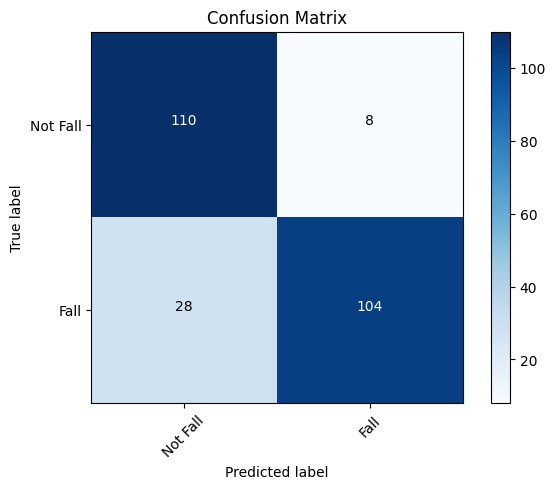

In [27]:
# test the quantized model
X_test_int8 = X_test.astype('float32')
y_test_int8 = y_test.astype('int8')
# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_content= pruned_qat_tflite_model)
# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_int8):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

gt = np.argmax(y_test_int8, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(gt, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
#accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
#print('accuracy: ', accuracy_fp)

f1_score = 2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0])
print('f1_score: ', f1_score)


In [29]:
# compare the size of the pruned model and the full-precision model
print('Size of the pruned QAT model: ', get_gzipped_model_size('./saved_models/'+model_name+'_pqat.tflite'))
print('Size of th QAT model: ', get_gzipped_model_size('./saved_models/'+model_name+'_qat.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('./saved_models/'+model_name+'.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('saved_models/'+ model_name+ '.tflite') / get_gzipped_model_size('./saved_models/'+model_name+'_pqat.tflite')))


Size of the pruned QAT model:  33275
Size of th QAT model:  42843
Size of the full-precision model:  120106
The achieved compression ratio is 3.61x
